# Validation
In this notebook, we will apply several classification algorithms on two data set: *Iris* and *Digits*. The first one is a low dimensional data set while the second one contains more features. This is used to illustrate  cross validation principles

### $k$ fold Cross Validation Algorithm

`Input`: input variables $X$ (dimension $n \times p$), responses $y$ (dimension n), number of folds $k$

`Divide` randomly the set $\{1, 2, ..., n\}$ in $k$ subsets (i.e., folds) of roughly equal sizes (e.g., size equals to the integer part of $n/k$ with a little smaller last part if $n$ is not a multiple of $k$) denoted as $F_1,\ldots,F_{k}$

`for i=1 to k:`
  * `Form` the validation set $(X_{val}, y_{val})$ where the indexes of the $X$ and $y$ variables belongs to the $i$th fold $F_i$
  * `Form` the training set $(X_{train}, y_{train})$  where the indexes of the $X$ and $y$ variables belongs to all the folds except $F_i$
  * `Train` the algorithm/model on the training set $(X_{train}, y_{train})$
  * `Apply` the resulting prediction rule on the input  $X_{val}$ of the validation set
  * `Compute` the error rate on the validation set based on the predictions and the true responses $y_{val}$

`Output`: the average error rate computed over all the $k$ folds

In [1]:
from sklearn.datasets import load_digits, load_iris
# Load digits
X, y = load_digits(return_X_y=True) # load_iris(return_X_y=True)
print(X.shape)
print(X.max())

(1797, 64)
16.0


# Visualization of the digits data set
The data set is made available *by NIST to extract normalized bitmaps of handwritten digits from a preprinted form. From a total of 43 people, 30 contributed to the training set and different 13 to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of 4x4 and the number of on pixels are counted in each block. This generates an input matrix of 8x8 where each element is an integer in the range 0..16* (https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits)

It is possible to visualize the data by reshaping correctly each sample:

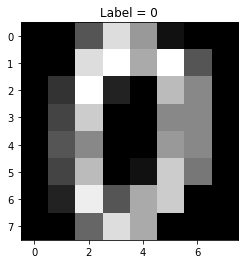

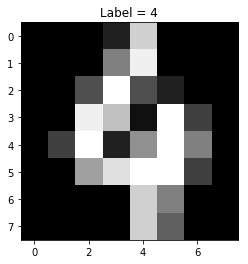

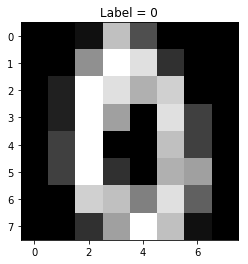

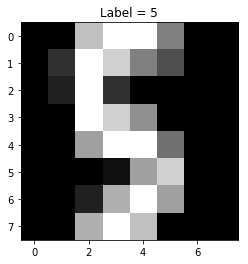

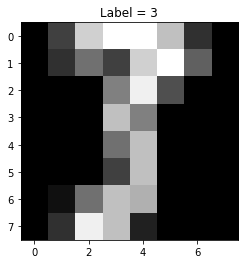

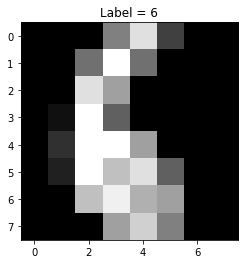

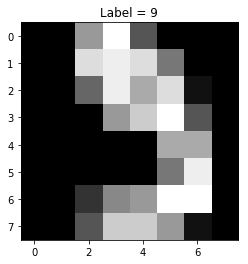

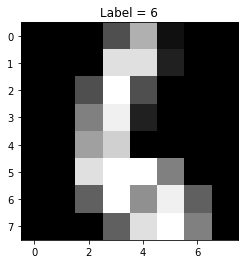

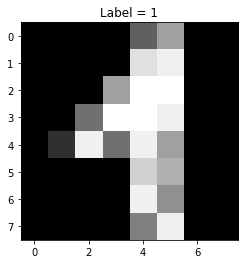

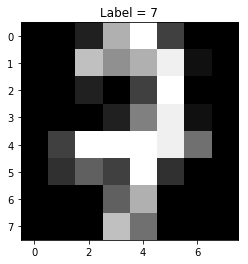

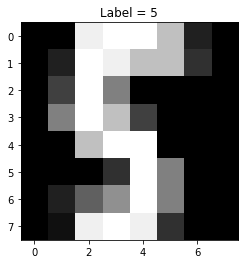

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot the first element
plt.figure()
plt.imshow(X[0,:].reshape(8,8),cmap="gray")
plt.title("Label = {}".format(y[0]))

# Plot the hundredth element
ith= 100
for ith in range(100,110):
    plt.figure()
    plt.imshow(X[ith,:].reshape(8,8),cmap="gray")
    plt.title("Label = {}".format(y[ith]))


## Classification framework
Two steps are required
- Model selection, i.e. find the optimal hyperparemeters,
- Model assessement, i.e. validate the model on unseen data.

As said in introduction, scikit-learn offers convenient and generic functions to achieve these steps. In what follow, an example is given for SVM. But it can be extended for any algorithm in scikit-learn, up to a correct definition of the hyperparameters. In this labworks, we use the support vector classifier (SVC) (http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

In [3]:
import scipy as sp
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

# Standardize data
sc = MinMaxScaler()
X = sc.fit_transform(X) # Scale data between 0 and 1

# Split the data -> test_size=0.20 means we keep 20% of the data for training and 80% for validation
# The stratification ensures that the proportion of each class from the orginal data is preserved in the train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.80, random_state=0, stratify=y)

With kernel methods (and more generaly for any distance based methods), it is a good practice to standardize feature remove dynamics effect. Here we rescale each feature between 0 and 1.

In [34]:
# Definition of the hyperparameters values search
degree = sp.arange(1,7) # Degree of the polynomial kernel
C = 10.0**sp.arange(0,5) # Penality of the optimization problem
param_grid = dict(degree=degree, C=C, kernel=['poly'],gamma=['auto'])
param_grid['C']

array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04])

We use [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html) strategy to select the optimal set of hyperparameters.

In [35]:
grid = GridSearchCV(SVC(),  # Set up the classifier
                    param_grid=param_grid, 
                    cv= 5,
                    iid=False,
                    n_jobs=-1) # Do the grid search in parallel
grid.fit(X_train, y_train) # Run the grid search

# Print some results
print("Best score: {}".format(grid.best_score_)) # Default scorer in scikit is the correct classification rate
print("Best set of hyperparameters: {}".format(grid.best_params_))

# Learn the optimal model
clf = grid.best_estimator_  # Get the best estimator
clf.fit(X_train,y_train)  # Fit it using the training set

# Predict new samples
y_pred = clf.predict(X_test)

# Compute the overall accuracies
print("Correct classification rate on the test set: {}".format(accuracy_score(y_test,y_pred)))

Best score: 0.9695310323479338
Best set of hyperparameters: {'C': 1000.0, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}
Correct classification rate on the test set: 0.9694019471488178


We can plot the correct classification rate function of the hyperparameters. It is important to check if our search values are correct.

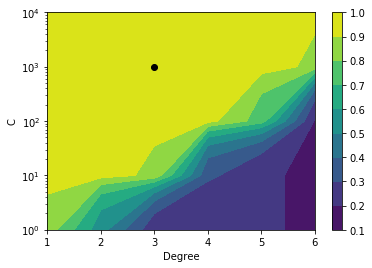

In [36]:
res = grid.cv_results_['mean_test_score'].reshape(C.size,degree.size)
X, Y = sp.meshgrid(degree, C)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
cp = ax.contourf(X, Y, res)
ax.scatter(grid.best_params_['degree'],grid.best_params_['C'],color='k')
ax.set_yscale("log")
ax.set_xlabel("Degree")
ax.set_ylabel("C")
fig.colorbar(cp)
plt.show() 

Now suppose we would like to compare several kernels. We need can use the same workflow, just by adding one line and modifying one line !!

In [37]:
gamma = 2.0**sp.arange(-4,2) # Scale of the RBF kernel

In [38]:
param_grid = [dict(kernel=['rbf'],gamma=gamma, C=C),
              dict(kernel=['poly'],degree=degree, C=C)]

We can now now copy/past/run the same code than previously:

In [39]:
grid = GridSearchCV(SVC(),  # Set up the classifier
                    param_grid=param_grid, 
                    cv= 5,
                    iid=False,
                    n_jobs=-1) # Do the grid search in parallel

grid.fit(X_train, y_train) # Run the grid search
print("Best score: {}".format(grid.best_score_))
print("Best set of hyperparameters: {}".format(grid.best_params_))
print
# Learn the optimal model
clf = grid.best_estimator_  # Get the best estimator
clf.fit(X_train,y_train)  # Fit it using the training set

# Predict new samples
y_pred = clf.predict(X_test)

# Compute the overall accuracies
print("Correct classification rate on the test set: {}".format(accuracy_score(y_test,y_pred)))

Best score: 0.9718423360676882
Best set of hyperparameters: {'C': 10.0, 'gamma': 0.125, 'kernel': 'rbf'}
Correct classification rate on the test set: 0.972183588317107


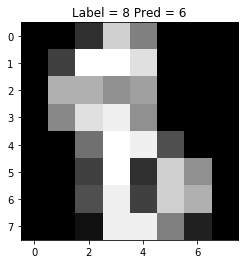

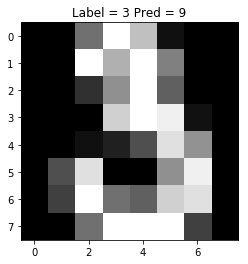

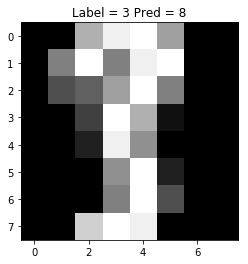

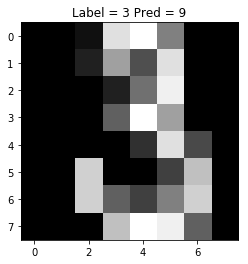

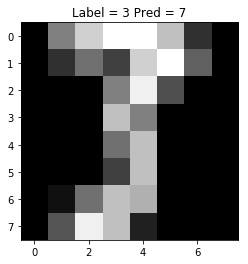

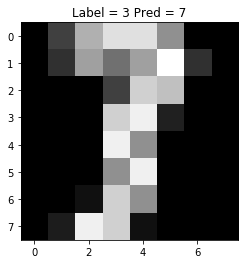

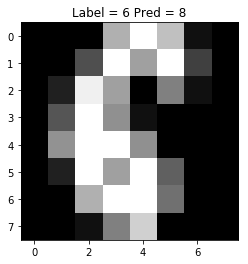

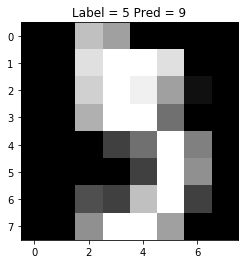

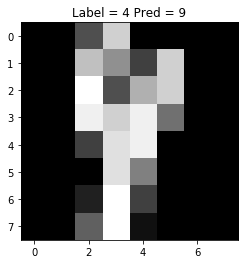

In [40]:
# Errors
t = sp.where(y_pred!=y_test)[0]
for t_ in t[1:10]:
    plt.figure()
    plt.imshow(X_test[t_,:].reshape(8,8),cmap="gray")
    plt.title("Label = {} Pred = {}".format(y_test[t_],y_pred[t_]))



## Comparison of the differents classifiers
In the course, we have discussed about three classifiers: QDA, SVM and K-NN. Using the following scripts, we are going to compare their performances on the given data sets. Again, using scikit-learn generic function, it is possible we few lines of code to run all the experiments.


### Show details for k-NN classifier

In [45]:
# Afficher les performances correspondantes
score = 'accuracy'
param_grid = {'n_neighbors':[1, 3, 5, 7, 9, 11, 13, 15]}

clf = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv= 5, scoring=score, iid=False)
clf.fit(X_train, y_train)

clf.best_estimator_  
    
print("Résultats de la validation croisée :")
print( clf.best_params_ )
for mean, std, params in zip(clf.cv_results_['mean_test_score'], # score moyen
clf.cv_results_['std_test_score'], # écart-type du score
clf.cv_results_['params'] # valeur de l'hyperparamètre
):
    print("\t%s = %0.3f (+/-%0.03f) for %r" % (score, # critère utilisé
                                            mean, # score moyen
                                            std * 2, # barre d'erreur
                                            params # hyperparamètre
                                            ) )
y_pred = clf.predict(X_test)
print("\nSur le jeu de test : %0.3f" % metrics.accuracy_score(y_test, y_pred) )


Résultats de la validation croisée :
{'n_neighbors': 1}
	accuracy = 0.977 (+/-0.046) for {'n_neighbors': 1}
	accuracy = 0.964 (+/-0.069) for {'n_neighbors': 3}
	accuracy = 0.966 (+/-0.059) for {'n_neighbors': 5}
	accuracy = 0.947 (+/-0.075) for {'n_neighbors': 7}
	accuracy = 0.953 (+/-0.054) for {'n_neighbors': 9}
	accuracy = 0.937 (+/-0.063) for {'n_neighbors': 11}
	accuracy = 0.923 (+/-0.072) for {'n_neighbors': 13}
	accuracy = 0.923 (+/-0.067) for {'n_neighbors': 15}

Sur le jeu de test : 0.962


## Pipeline
In the previous section, we have selected the best kernel from the polynomial and RBF one. But it is also possible to combine them using [pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) facility offer by scikit-learn. The following code does the job. 

We first define the CompositeKernel class, which is the weighted summation of the RBF and polynomial kernel with their own parameters.

In [46]:
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# Convenient Class for summation kernel
class CompositeKernel(BaseEstimator,TransformerMixin):
    def __init__(self,
                 mu=0.5,
                 gamma=0.125,  
                 degree=3):
        self.gamma = gamma
        self.degree = degree
        self.mu = mu
        
    def transform(self,X):
        K = self.mu*rbf_kernel(X,self.X_,gamma=self.gamma)
        K += (1-self.mu)*polynomial_kernel(X,self.X_,degree=self.degree)
        return K

    def fit(self,X,y=None, **fit_params):
        self.X_ = X
        return self

Then we define the pipeline:

In [47]:
# Create a pipeline
pipe = Pipeline([
    ('CK',CompositeKernel()),
    ('SVM',SVC())
])

Then we define the range search for the weight paramter *mu* and pass the others parameters ranges. Here we are going to optimize all the parameters using grid search, i.e., a  brute force strategy. It exists several algorithms to do it properly, e.g., https://arxiv.org/abs/1602.02355. 

In [51]:
param_grid = dict([
    ('CK__mu', sp.linspace(0,1,num=11)),  # Note the double "_" to define parameters of a pipeline
    ('CK__gamma', gamma),
    ('CK__degree', degree),
    ('SVM__C',C),
    ('SVM__kernel', ['precomputed']),
])
grid = GridSearchCV(pipe,  # Set up the classifier -> Here we put our pipeline
                    param_grid=param_grid, 
                    cv= 3,
                    iid=False,
                    n_jobs=-1) # Do the grid search in parallel

grid.fit(X_train, y_train) # Run the grid search and WAIT: 11*6*6*4 tuples of values to be tested !
print("Best score: {}".format(grid.best_score_))
print("Best set of hyperparameters: {}".format(grid.best_params_))

# Learn the optimal model
clf = grid.best_estimator_  # Get the best estimator
clf.fit(X_train,y_train)

# Predict new samples
y_pred = clf.predict(X_test)

# Compute the overall accuracies
print(accuracy_score(y_test,y_pred))

Best score: 0.9721257256696393
Best set of hyperparameters: {'CK__degree': 1, 'CK__gamma': 0.25, 'CK__mu': 0.2, 'SVM__C': 10.0, 'SVM__kernel': 'precomputed'}
0.9714881780250347
